<a href="https://colab.research.google.com/github/huangzehao/laboratory/blob/main/fourier_feature_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
"""
https://github.com/tancik/fourier-feature-networks
"""
import imageio
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


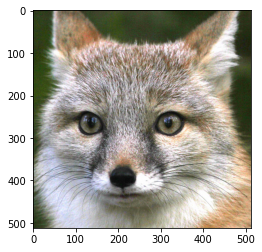

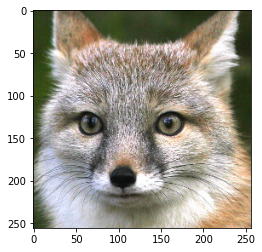

In [40]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2,::2], img[::2,::2]]

plt.imshow(img)
plt.show()
plt.imshow(img[::2, ::2])
plt.show()

In [53]:
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = (2.*np.pi*x) @ B.T
        return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

class Net(nn.Module):
    def __init__(self, num_layers, num_channels, input_channels):
        super().__init__()

        layers = []
        output_channels = 3 # (r, g, b)
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_channels, num_channels))
            layers.append(nn.ReLU())
            input_channels = num_channels
        layers.append(nn.Linear(input_channels, output_channels))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

def train_model(network_size, learning_rate, iters, B, train_data, test_data):
    _x = input_mapping(train_data[0], B)
    net = Net(*network_size, _x.shape[-1])
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    criterion = lambda x, y: 0.5 * torch.mean((x - y) ** 2)
    psnr = lambda x, y: -10 * torch.log10(2 * criterion(x, y))
    
    train_psnrs = []
    
    net.train()
    for i in tqdm(range(iters)):
        data, label = train_data
        data = input_mapping(data.reshape((-1, 2)), B)
        label = label.reshape((-1, 3))

        data = torch.FloatTensor(data).to(device)
        label = torch.FloatTensor(label).to(device)

        pred = net(data)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        if i % 25 == 0:
            train_psnr = psnr(pred, label).detach().item()
            train_psnrs.append(train_psnr)
    
    net.eval()
    data, label = test_data
    h, w = data.shape[:2]
    data = input_mapping(data.reshape((-1, 2)), B)
    label = label.reshape((-1, 3))
    data = torch.FloatTensor(data).to(device)
    label = torch.FloatTensor(label).to(device)
    pred = net(data)
    test_psnr = psnr(pred, label).detach().item()
    pred_img = pred.detach().cpu().numpy().reshape((h, w, 3))
    return train_psnrs, test_psnr, pred_img

100%|██████████| 2/2 [04:45<00:00, 142.63s/it]


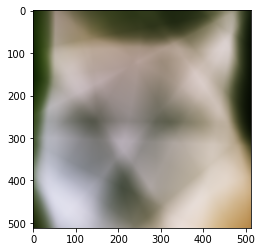

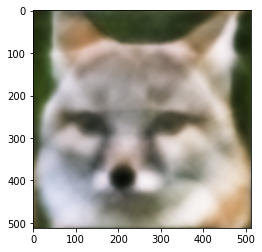

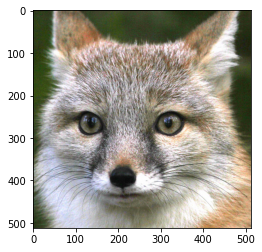

In [55]:
network_size = (4, 256)
learning_rate = 1e-4
iters = 2000
mapping_size = 256

B_dict = {}
B_dict['none'] = None
B_dict['basic'] = np.eye(2)
# B_gauss = np.random.normal(0, (mapping_size, 2))
# for scale in [1., 10., 100.]:
    # B_dict[f'gauss_{scale}'] = B_gauss * scale

outputs = {}
for k in tqdm(B_dict):
    outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)
for k in B_dict:
    train_psnrs, test_psnr, pred_img = outputs[k]
    plt.imshow(pred_img)
    plt.show()
plt.imshow(test_data[1])
plt.show()